In [4]:
# 加载音频文件
from scipy.io import wavfile

def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [5]:
import numpy as np

# 获取 MAN 文件
def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    slotCnt = int(slotCnt)
    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

# 获取 MAN 文件
def GenerateManSeqSec(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    lis = []

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second
        lis.append(stime)

    return lis

In [6]:
# 生成编号数列

def GetPreSeq(manSeq, length):
    preSeq = manSeq.copy()
    for i in range(1, len(preSeq)):
        preSeq[i] ^= preSeq[i - 1]
        
    assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))
    return preSeq[:length]

<ipython-input-6-a1912e3b4ef1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))


In [7]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html
def mfcc(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 512
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 三、滤波器组(Filter Banks)
    # The final step to computing filter banks is applying triangular filters,
    # typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands.
    # convert frequency(f) and Mel(m) with equations:
    # m = 2595 * log10(1 + f / 700)
    # f = 700 * (10 ^ (m / 2595) - 1)
    n_filters = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # need 40 filters banks, so need 42 points
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # convert Mel to Hz
    # bin = sample_rate / NFFT  # fequency bin equation
    bins = np.floor((NFFT + 1) * hz_points / sample_rate)  # hz_points / bin

    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bins[m - 1])
        f_m = int(bins[m])
        f_m_plus = int(bins[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

    # pl.plot(fbank.T)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("time()")
    # pl.title("40 Filter Banks")
    # pl.show()

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # db

    # pl.plot(filter_banks)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("Time")
    # pl.title("Spectrogram")
    # pl.show()

    # 四、梅尔频率倒谱系数(MFCCs)
    # apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients
    # and yield a compressed representation of the filter banks.
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 2: (num_ceps + 2)]  # keep 3-14

    # apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
    (n_frames, n_coeff) = mfcc.shape
    n = np.arange(n_coeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [24]:
def GetMode(segment, K):
    cnt = [0] * K
    for i in range(len(segment)):
       cnt[segment[i]] += 1.0 / len(segment)
    return cnt

def GetKMeans(get_mfcc, K, WINDOW_LEN):
    from sklearn.preprocessing import StandardScaler
    data = get_mfcc.copy()

    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)

    from sklearn.cluster import KMeans
    kmeans = KMeans(K)
    kmeans.fit(data_scaled)
    mem = kmeans.labels_

    mem_reduce = [0] * len(mem)
    for i in range(len(mem_reduce)):
        mem_reduce[i] = GetMode(mem[max(i-WINDOW_LEN, 0) : min(i + WINDOW_LEN, len(mem_reduce))], K)
    mem_reduce = np.array(mem_reduce)

    return mem_reduce

def ShowMapForWav(wavFileName, manFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]
    print("MUSIC_ID:", music_id)

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    # 总秒数 
    # totalTime = len(signal) // sample_rate

    manSeq = GenerateManSeq(len(signal) // RATE, manFileName, RATE, sample_rate, 1)
    
    get_pre = GetPreSeq(manSeq, len(get_mfcc))
    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, wtmp)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()
    # for i in range(mem_blank.shape[0]):
    #    for j in range(mem_blank.shape[1]):
    #        if mem_blank[i][j] >= ALPHA:
    #            mem_blank[i][j] = 1
    #        elif mem_blank[i][j] >= ALPHA * 0.9:
    #            mem_blank[i][j] = 0.5
    #        else:
    #            mem_blank[i][j] = 0

    # 总帧数
    # totalCnt = len(mem_blank)
    plt.figure(figsize=(19, 5))

    print("SHAPE:", mem_blank.shape, len(get_pre))
    if mem_blank.shape[0] != len(get_pre):
        mem_blank = mem_blank[:len(get_pre),:]
        print("SHAPE:", mem_blank.shape, len(get_pre))


    import seaborn as sns
    sns.heatmap(np.c_[mem_blank, get_pre].T)

    # 要先保存再显示
    plt.savefig('./Data/NEWPIC/%s.png' % music_id)
    plt.show()

MUSIC_ID: 0003
sample_rate:44100, len:6290188
sample_rate:44100, len:6290188
SHAPE: (28525, 6) 28524
SHAPE: (28524, 6) 28524


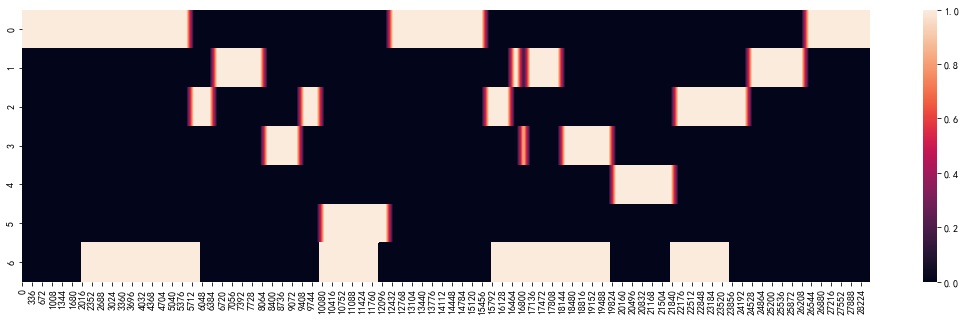

MUSIC_ID: 0004
sample_rate:44100, len:4896864
sample_rate:44100, len:4896864
SHAPE: (22206, 6) 22206


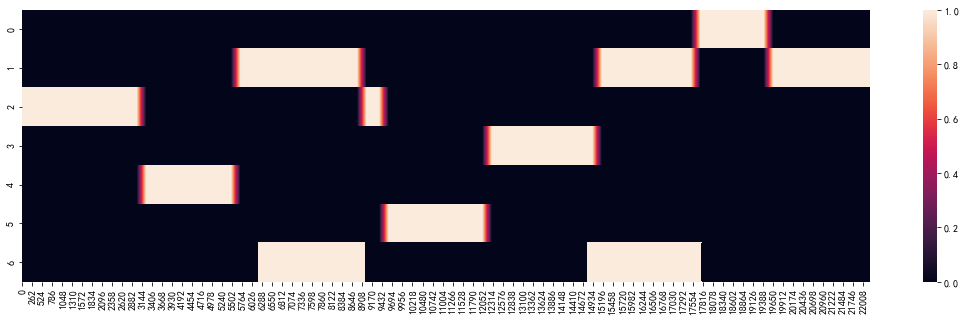

MUSIC_ID: 0005
sample_rate:44100, len:9821184
sample_rate:44100, len:9821184
SHAPE: (44539, 6) 44539


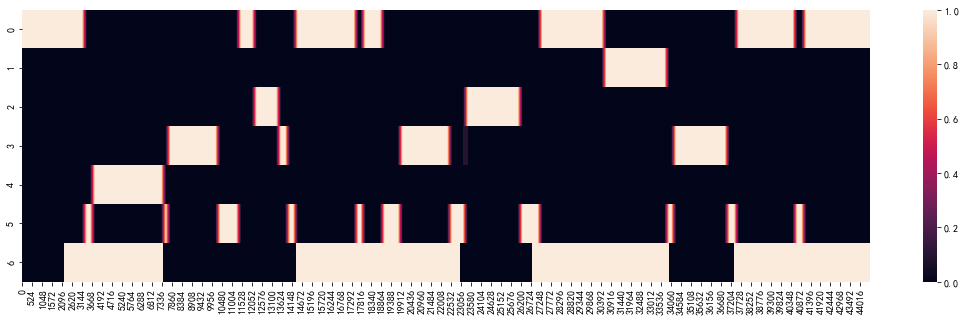

MUSIC_ID: 0006
sample_rate:44100, len:8997888
sample_rate:44100, len:8997888
SHAPE: (40805, 6) 40805


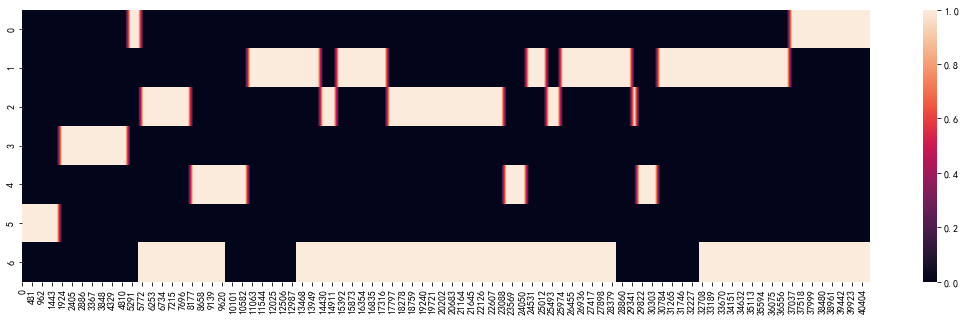

MUSIC_ID: 0007
sample_rate:44100, len:9069568
sample_rate:44100, len:9069568
SHAPE: (41130, 6) 41129
SHAPE: (41129, 6) 41129


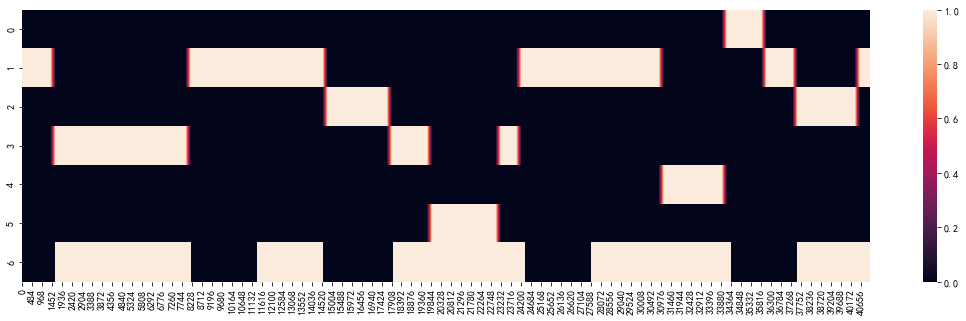

MUSIC_ID: 0008
sample_rate:44100, len:10831872
sample_rate:44100, len:10831872
SHAPE: (49122, 6) 49121
SHAPE: (49121, 6) 49121


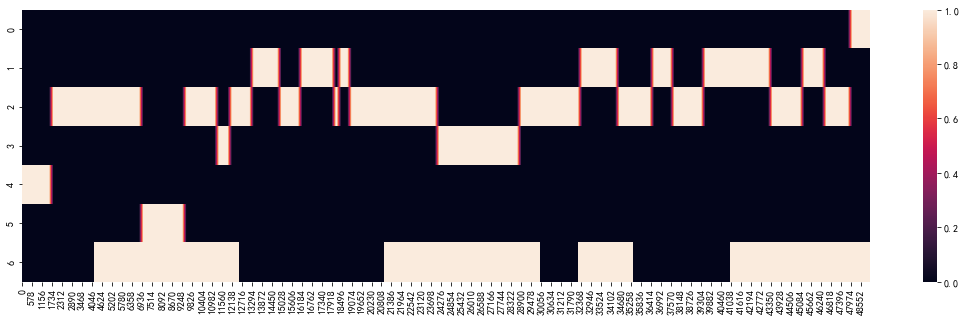

MUSIC_ID: 0009
sample_rate:44100, len:10860544
sample_rate:44100, len:10860544
SHAPE: (49252, 6) 49251
SHAPE: (49251, 6) 49251


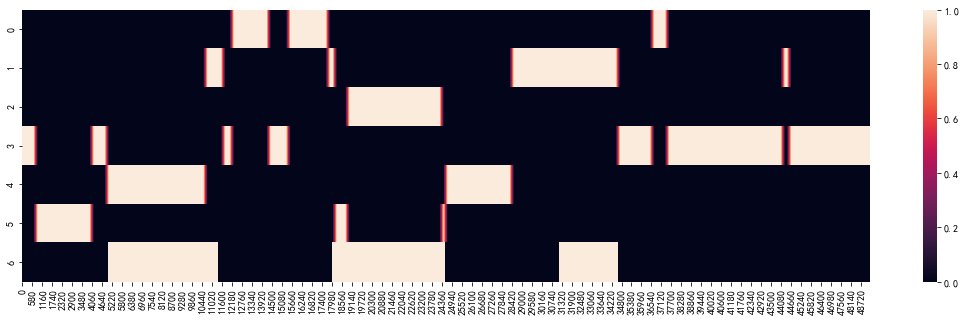

MUSIC_ID: 0010
sample_rate:48000, len:10515456
sample_rate:48000, len:10515456
SHAPE: (43812, 6) 43811
SHAPE: (43811, 6) 43811


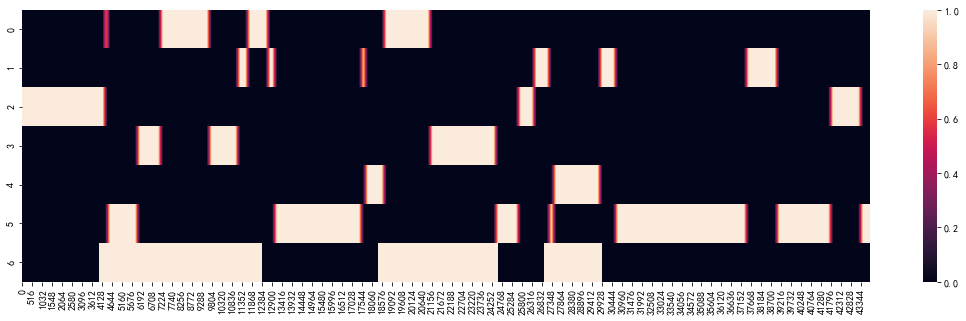

MUSIC_ID: 0011
sample_rate:44100, len:12812288
sample_rate:44100, len:12812288
SHAPE: (58104, 6) 58103
SHAPE: (58103, 6) 58103


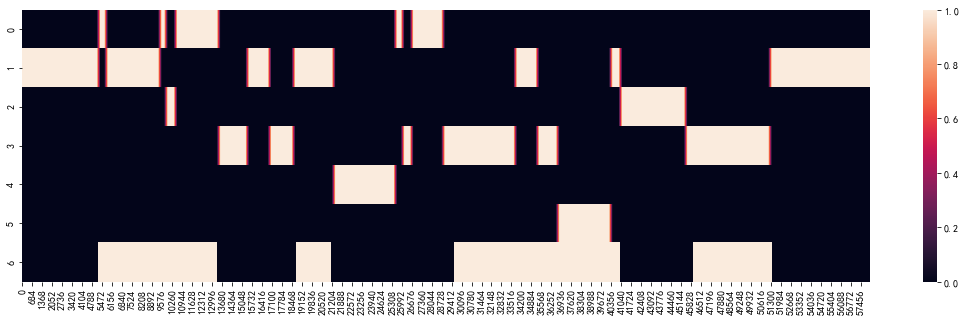

MUSIC_ID: 0012
sample_rate:48000, len:8999936
sample_rate:48000, len:8999936
SHAPE: (37498, 6) 37498


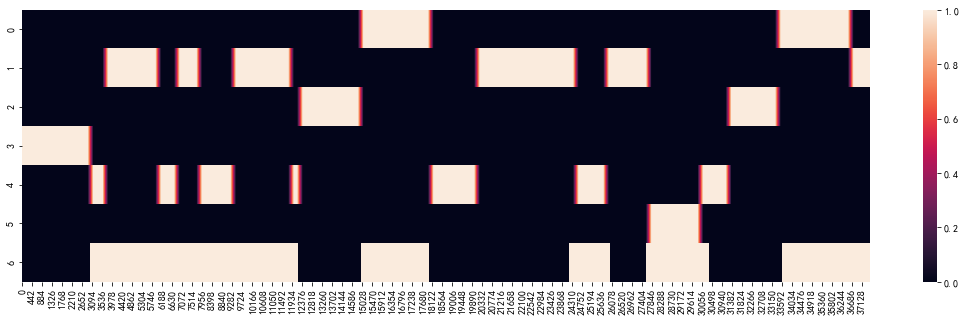

MUSIC_ID: 0013
sample_rate:44100, len:9261056
sample_rate:44100, len:9261056
SHAPE: (41998, 6) 41997
SHAPE: (41997, 6) 41997


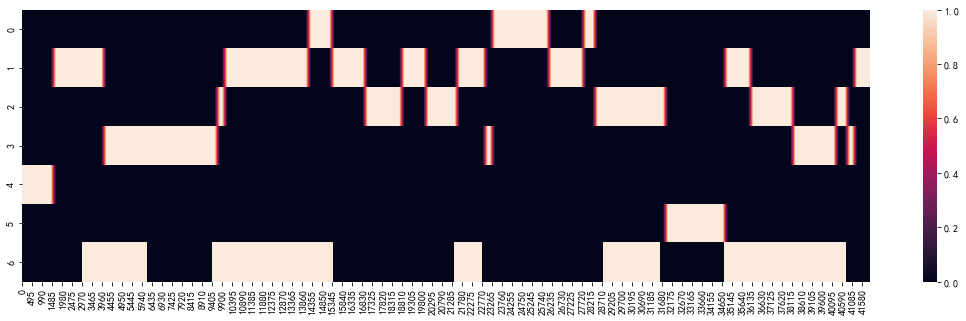

MUSIC_ID: 0014
sample_rate:44100, len:9679872
sample_rate:44100, len:9679872
SHAPE: (43898, 6) 43897
SHAPE: (43897, 6) 43897


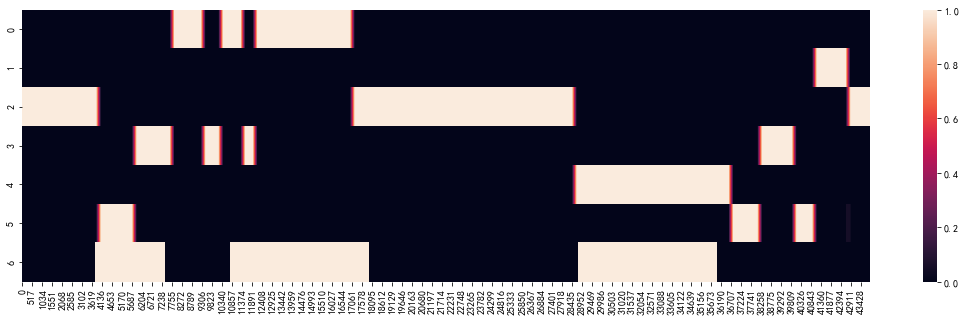

MUSIC_ID: 0015
sample_rate:48000, len:12466176
sample_rate:48000, len:12466176
SHAPE: (51940, 6) 51940


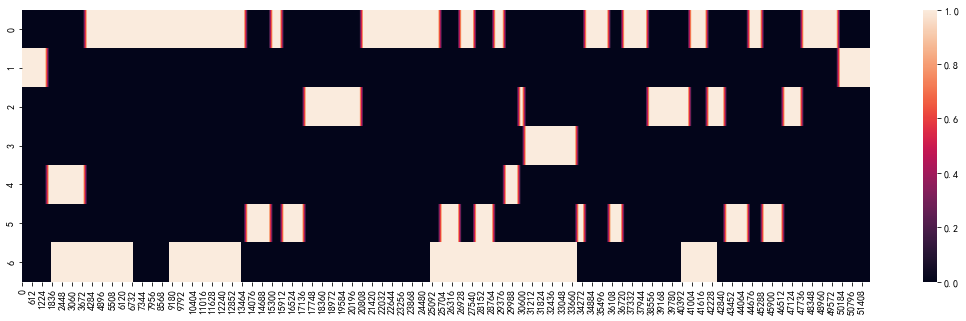

MUSIC_ID: 0016
sample_rate:48000, len:12241920
sample_rate:48000, len:12241920
SHAPE: (51006, 6) 51005
SHAPE: (51005, 6) 51005


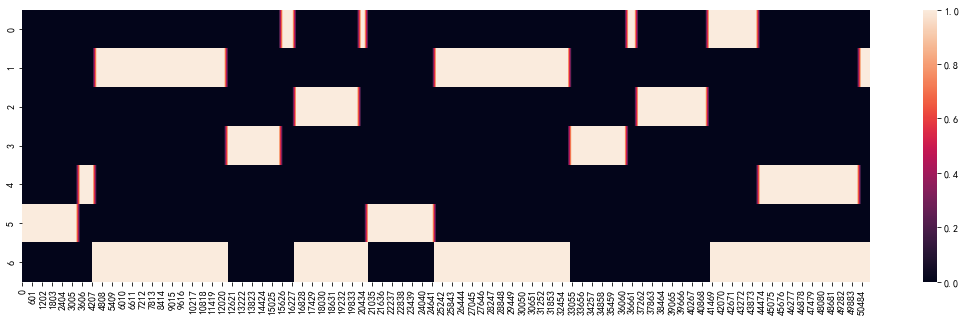

MUSIC_ID: 0017
sample_rate:48000, len:9960448
sample_rate:48000, len:9960448
SHAPE: (41500, 6) 41500


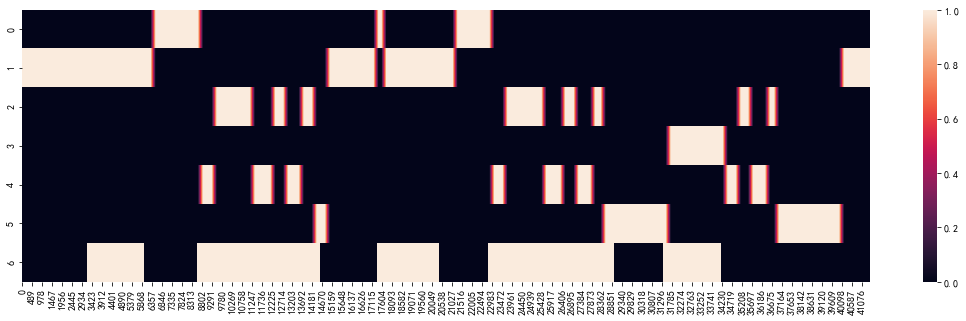

MUSIC_ID: 0018
sample_rate:48000, len:13970432
sample_rate:48000, len:13970432
SHAPE: (58208, 6) 58207
SHAPE: (58207, 6) 58207


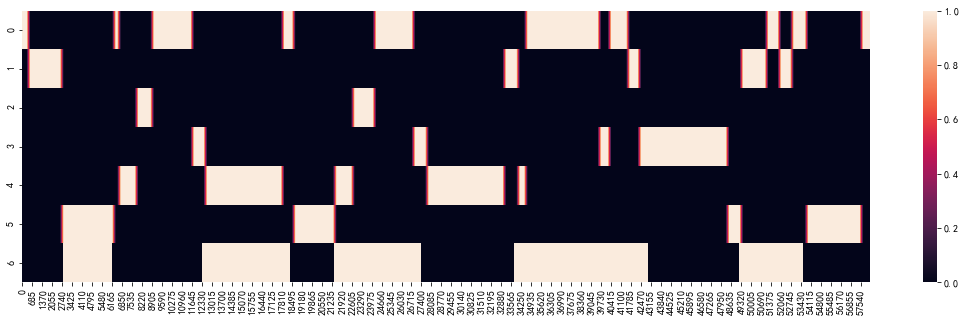

MUSIC_ID: 0019
sample_rate:44100, len:8112128
sample_rate:44100, len:8112128
SHAPE: (36788, 6) 36787
SHAPE: (36787, 6) 36787


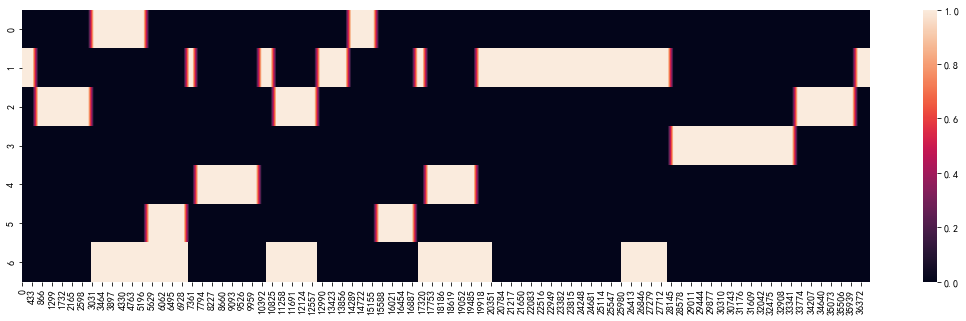

MUSIC_ID: 0020
sample_rate:44100, len:14675968
sample_rate:44100, len:14675968
SHAPE: (66556, 6) 66555
SHAPE: (66555, 6) 66555


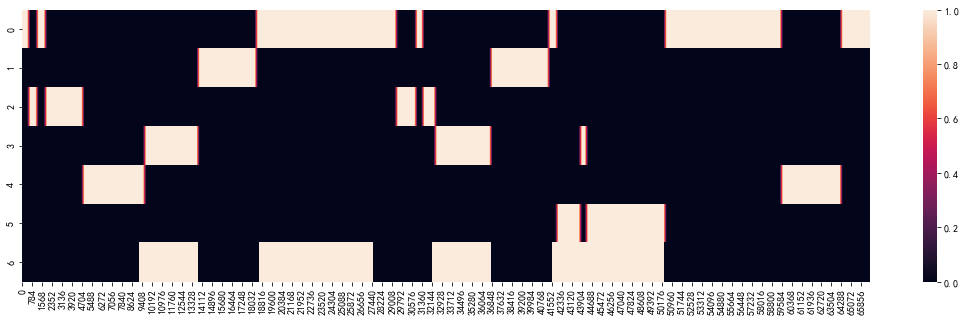

MUSIC_ID: 0021
sample_rate:48000, len:10848256
sample_rate:48000, len:10848256
SHAPE: (45199, 6) 45198
SHAPE: (45198, 6) 45198


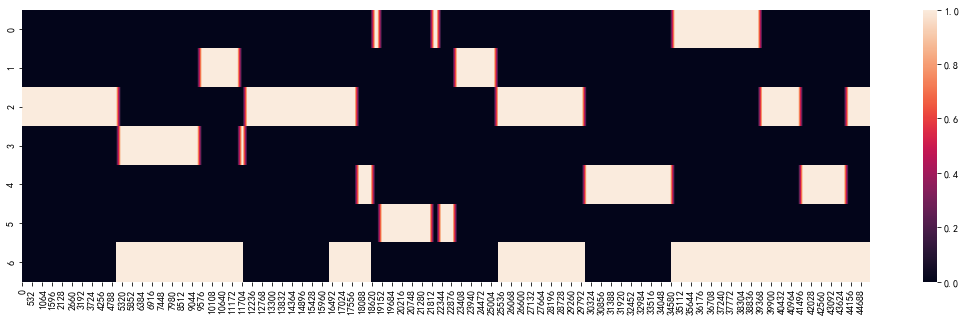

MUSIC_ID: 0022
sample_rate:48000, len:10139648
sample_rate:48000, len:10139648
SHAPE: (42247, 6) 42247


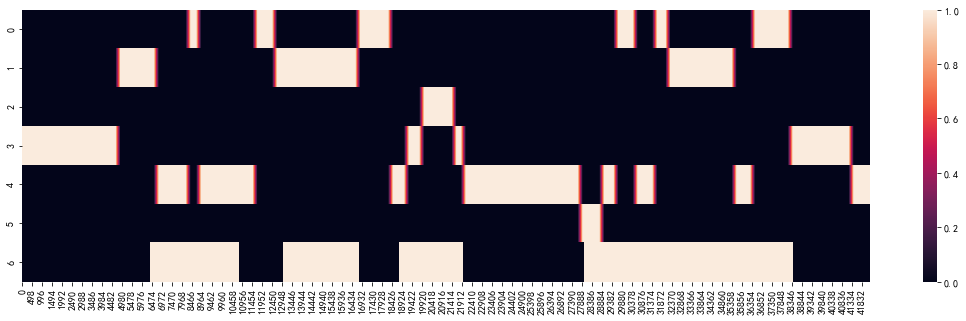

MUSIC_ID: 0023
sample_rate:48000, len:11297792
sample_rate:48000, len:11297792
SHAPE: (47072, 6) 47071
SHAPE: (47071, 6) 47071


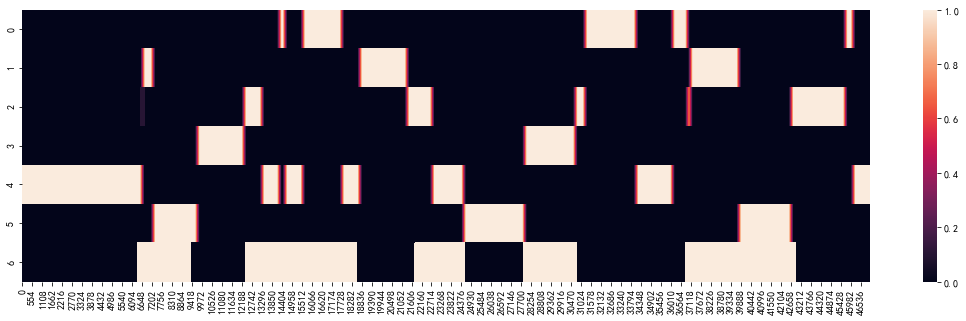

MUSIC_ID: 0024
sample_rate:48000, len:13300736
sample_rate:48000, len:13300736
SHAPE: (55418, 6) 55417
SHAPE: (55417, 6) 55417


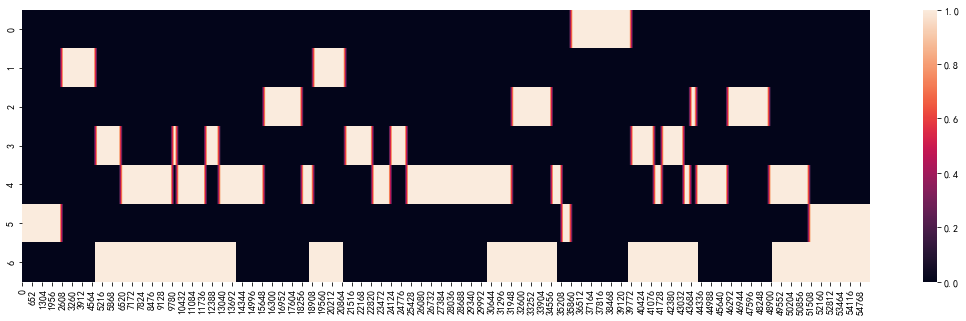

MUSIC_ID: 0025
sample_rate:48000, len:11916288
sample_rate:48000, len:11916288
SHAPE: (49649, 6) 49649


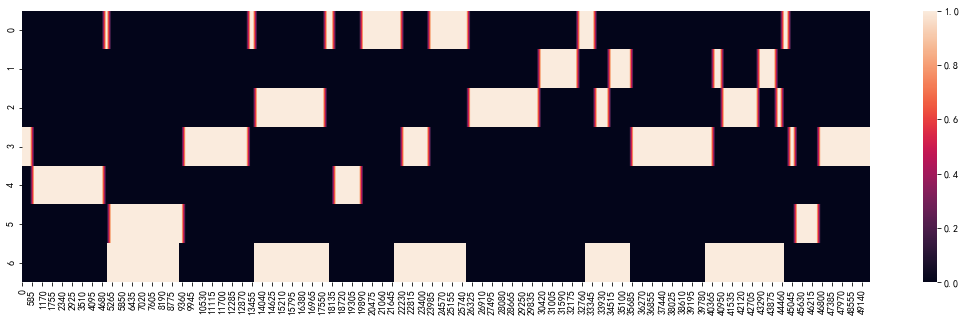

MUSIC_ID: 0026
sample_rate:48000, len:11528192
sample_rate:48000, len:11528192
SHAPE: (48032, 6) 48032


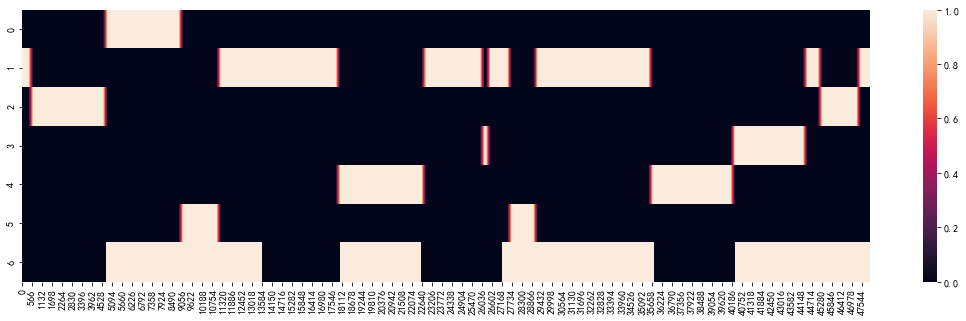

In [26]:
N = 26
for i in range(3, N + 1):
    name = "%04d" % i
    ShowMapForWav("./Data/WAV/%s.wav" % name, "./Data/MAN/%s.man" % name)